An autoencoder __encodes data in a latent-space__ minimizing the reconstruction error.

<img src="https://miro.medium.com/max/1200/1*ViBG49eTCKqqO2UVRL9mEw.png" width="500px"/>

It is composed by:

- encoder (E): encodes the data in the latent-space (as a *code*);
- decoder (D): reconstructs the data from the latent-space representation.

Depending on the code size:

- __undercomplete__: dimensionality reduction, classical case;
- __overcomplete__: code bigger, without additional constraints the identity funciton is learned.

The objective is generating an output as close as possible to the input.

One immediate choice for the loss is MSE:

$$\Large
\mathcal{L}(\{x,\hat{x}\}) = \sum_i \|x_i-\hat{x}_i\|^2
$$

In case of linear activations:

$$\large
\begin{eqnarray}
z &=& E(x) = W_E x + b_E \\
\hat{x} &=& D(z) = W_D z + b_D \\
        &=& W_D W_E x + W_D b_E + b_D \\
        &=& W_{AE} x + b_{AE} \\
\end{eqnarray}
$$

representing just a linear transformation with bias.

# Deep convolutional autoencoders

Deep is.. deep:

<img src="https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" width="500px"/>

Every block is convolutional (with activation).

## Convolutional autoencoders

Convolution is the base operation both in encoding and decoding.

Let's create one that encodes MNIST digits.

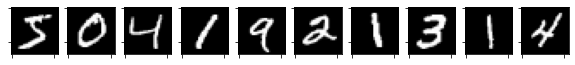

In [1]:
from typing import Optional
from torch import Tensor
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from torchvision.transforms import Compose, ToTensor, Normalize

# Mnist dataset:
def load_mnist(train: bool) -> Tensor:
    return MNIST(root='./data', train=train, download=True).data / 255

mnist_train = load_mnist(train=True)
mnist_test = load_mnist(train=False)

# Showing some digits:
def plot_images(images: Tensor, title: Optional[str] = None):
    """Images received as an (N,H,W) tensor."""
    n = images.shape[0]
    plt.figure(figsize=(n,1))
    for i in range(n):
        ax = plt.subplot(1,n,i+1)
        if i==0:
            plt.title(title)
        image = images[i,:,:].numpy()
        plt.imshow(image, cmap='gray')
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
    plt.show()

plot_images(mnist_train[0:10,:,:]);

### The encoder

In [193]:
from torch import Tensor
from torch.nn import Module, Sequential, Conv2d, LeakyReLU

class Encoder(Sequential):
    """Receives images 1x28x28 as (N,C,H,W)."""
    def __init__(self):
        super().__init__(
            DownBlock(1,4,3,1), # 14x14
            DownBlock(4,8,3,1), #  7x7
            DownBlock(8,32,7,sep=True),  #  1x1
        )
        
class DownBlock(Sequential):
    def __init__(self, ch_in, ch_out, kern, pad=0, sep=False):
        super().__init__(
            self._conv_sep(ch_in, ch_out, kern, pad) if sep
            else self._conv(ch_in, ch_out, kern, pad),
            LeakyReLU(),
        )
        
    def _conv(self, ch_in, ch_out, kern, pad) -> Module:
        return Conv2d(ch_in, ch_out, kernel_size=kern, stride=2, padding=pad)
        
    def _conv_sep(self, ch_in, ch_out, kern, pad) -> Module:
        return Sequential(
            Conv2d(ch_in, ch_in, kernel_size=kern, stride=2, padding=pad, groups=ch_in),
            Conv2d(ch_in, ch_out, kernel_size=1),
        )

def num_params(model):
    return sum(
        p.numel()
        for p in model.parameters()
        if p.requires_grad
    )

# The encoding shape:
t_in = mnist_train[0:4,None,:,:]
t_code = Encoder()(t_in)
print(f"{tuple(t_in.shape)} => {tuple(t_code.shape)}")
print(f"Encoder parameters: {num_params(Encoder())}")

(4, 1, 28, 28) => (4, 32, 1, 1)
Encoder parameters: 1024


### The decoder

In [194]:
from torch import Tensor
from torch.nn import Module, Sequential
from torch.nn import Conv2d, ConvTranspose2d, LeakyReLU

class Decoder(Sequential):
    """Receives embeddings as (N,C,H,W)."""
    def __init__(self):
        super().__init__(
            UpBlock(32,8,7,sep=True),   # 7x7
            UpBlock(8,4,3,1,1),         # 14x14
            UpBlock(4,1,3,1,1),         # 28x28
        )

class UpBlock(Sequential):
    def __init__(self, ch_in, ch_out, kern, pad = 0, opad = 0, sep=False):
        super().__init__(
            self._conv_sep(ch_in, ch_out, kern, pad, opad) if sep
            else self._conv(ch_in, ch_out, kern, pad, opad),
            LeakyReLU(),
        )
    
    def _conv(self, ch_in, ch_out, kern, pad, opad):
        return ConvTranspose2d(
            ch_in, ch_out, kernel_size=kern, stride=2,
            padding=pad, output_padding=opad,
        )
    
    def _conv_sep(self, ch_in, ch_out, kern, pad, opad):
        return Sequential(
            ConvTranspose2d(
                ch_in, ch_in, kernel_size=kern, stride=2,
                padding=pad, output_padding=opad, groups=ch_in,
            ),
            Conv2d(ch_in, ch_out, kernel_size=1),
        )
        
t_out = Decoder()(t_code)
print(f"{tuple(t_code.shape)} => {tuple(t_out.shape)}")
print(f"Decoder parameters: {num_params(Decoder())}")

(4, 32, 1, 1) => (4, 1, 28, 28)
Decoder parameters: 2193



### The convolutional autoencoder

In [195]:
class Autoencoder(Sequential):
    def __init__(self):
        super().__init__(
            Encoder(), 
            Decoder(), 
        )

ae = Autoencoder()
t_out = ae(t_in)
print(f"{tuple(t_in.shape)} => {tuple(t_out.shape)}")
print(f"Autoencoder parameters: {num_params(ae)}")

(4, 1, 28, 28) => (4, 1, 28, 28)
Autoencoder parameters: 3217


In [142]:
from typing import Tuple
from torch.utils.data import Dataset

class PairDataset(Dataset[Tuple[Tensor,Tensor]]):
    def __init__(self, xs: Dataset[Tensor], ys: Dataset[Tensor]):
        self._xs, self._ys = xs, ys
    
    def __getitem__(self, index: int) -> Tuple[Tensor, Tensor]:
        return self._xs[index][None,:,:], self._ys[index][None,:,:]
    
    def __len__(self) -> int:
        return self._xs.shape[0]

train_ds = PairDataset(mnist_train, mnist_train)
test_ds = PairDataset(mnist_test, mnist_test)

print(f"Train samples: {len(train_ds)}")
print(f"Test samples: {len(test_ds)}")

Train samples: 60000
Test samples: 10000


### Training the autoencoder

In [143]:
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torch import no_grad
from torch.optim import Adam
import numpy as np

def train(
    train_data, test_data,
    model, loss,
    epochs=10,
    lr=1e-2,
    batch=64,
) -> Tuple[Module, np.ndarray, np.ndarray]:
    train_dl = DataLoader(train_data, batch_size=batch, shuffle=True)
    test_dl = DataLoader(test_data, batch_size=batch, shuffle=True)
    
    test_loss = evaluate(model, loss, test_dl)
    print(f"test_loss_before = {test_loss}\n")

    final_loss_train = []
    final_loss_test = [test_loss]
    
    optim = Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        losses = []
        for x, y in train_dl:
            optim.zero_grad()
            y_hat = model(x)
            step_loss = loss(y_hat, y)
            losses.append(step_loss.item())
            step_loss.backward()
            optim.step()
            
        train_loss = np.mean(losses)
        test_loss = evaluate(model, loss, test_dl)
        final_loss_train.append(train_loss)
        final_loss_test.append(test_loss)
        print(f"train_loss[{epoch}] = {train_loss}")
        print(f"test_loss[{epoch}] = {test_loss}\n")
        
    final_loss_train.append(evaluate(model, loss, train_dl))
    return model, np.array(final_loss_train), np.array(final_loss_test)
            
def evaluate(model, loss, test_dl):
    model.eval()
    losses = []
    with no_grad():
        first = True
        for x, y in test_dl:
            y_hat = model(x)
            if first:
                plot_comparison(x, None, y_hat)
                first = False
            step_loss = loss(y_hat, y)
            losses.append(step_loss.item())
    return np.mean(losses)

def plot_comparison(x, y, y_hat):
    if x is not None:
        plot_images(x[:16,0,:,:], "Input")
    if y is not None:
        plot_images(y[:16,0,:,:], "GT")
    if y_hat is not None:
        plot_images(y_hat[:16,0,:,:], "Output")

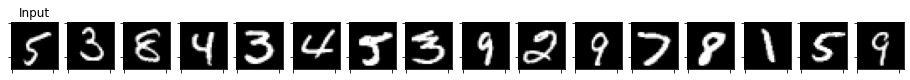

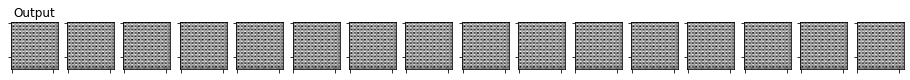

test_loss_before = 0.12535088789311183



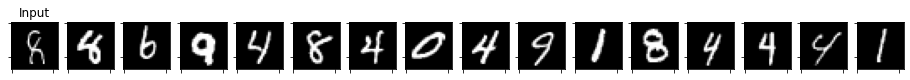

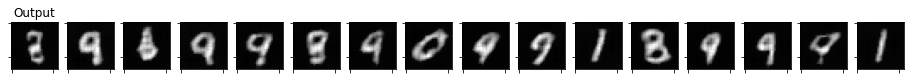

train_loss[0] = 0.03806501569381274
test_loss[0] = 0.02981946021792995



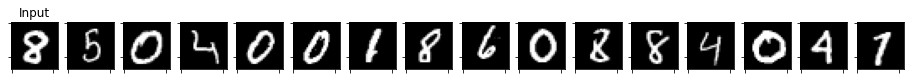

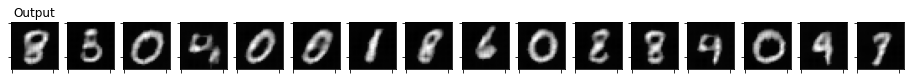

train_loss[1] = 0.029454042358613854
test_loss[1] = 0.028796672975276685



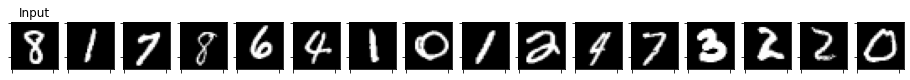

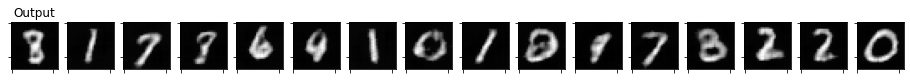

train_loss[2] = 0.028647557101540093
test_loss[2] = 0.027818007299759584



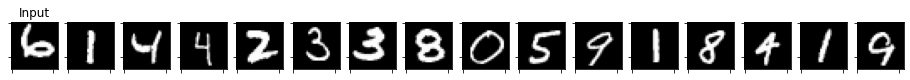

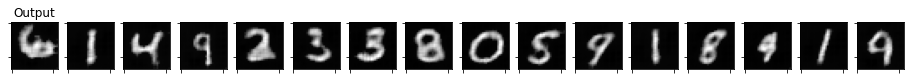

train_loss[3] = 0.02829747653600059
test_loss[3] = 0.028010107980222458



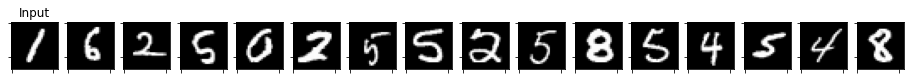

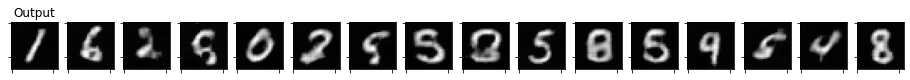

train_loss[4] = 0.027988869383105082
test_loss[4] = 0.027542566180608834



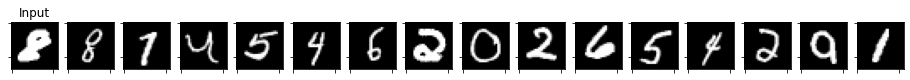

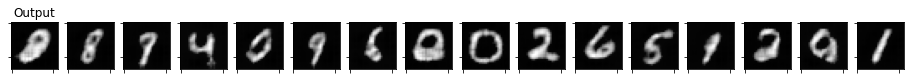

train_loss[5] = 0.027823727883732143
test_loss[5] = 0.027322502047487884



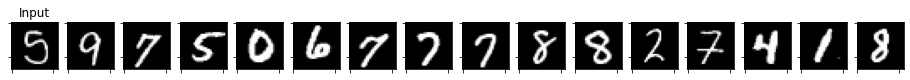

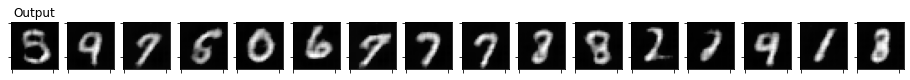

train_loss[6] = 0.027636432535708078
test_loss[6] = 0.027189627040628415



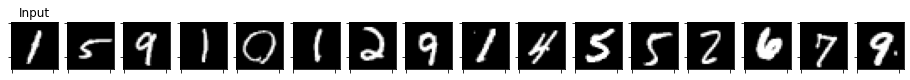

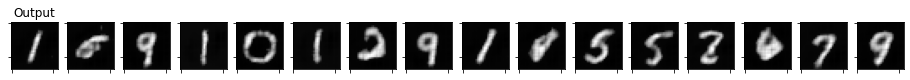

train_loss[7] = 0.027590318898688248
test_loss[7] = 0.027108687515945952



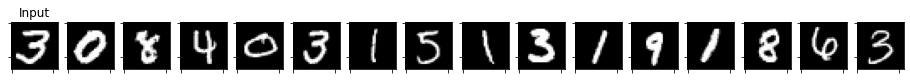

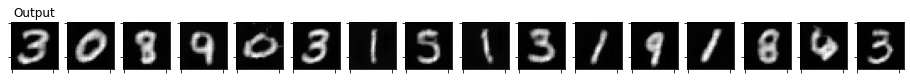

train_loss[8] = 0.0274640260351651
test_loss[8] = 0.027121357536714547



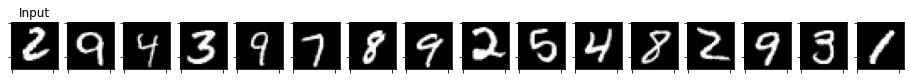

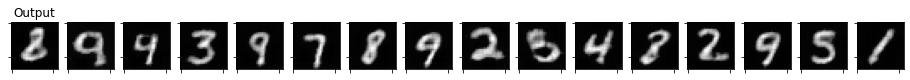

train_loss[9] = 0.027368274801321375
test_loss[9] = 0.02694485783814245



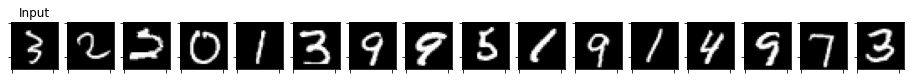

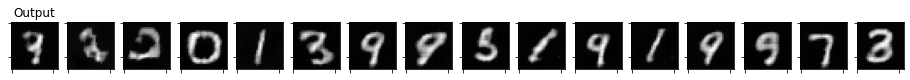

In [196]:
ae, loss_tr, loss_te = train(train_ds, test_ds, Autoencoder(), MSELoss())

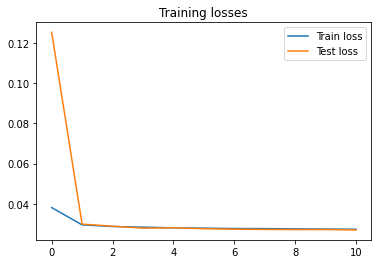

In [197]:
from matplotlib import pyplot as plt

def plot_losses(train, test):
    plt.figure()
    plt.plot(train)
    plt.plot(test)
    plt.title("Training losses")
    plt.legend(["Train loss","Test loss"])
    plt.show();

plot_losses(loss_tr, loss_te)

## Denoising autoencoders

Denoising autoencoders are autoencoders trained to output cleaned samples given noisy samples in input.

They learn a __noise correction vector space__:

<img src="https://qph.cf2.quoracdn.net/main-qimg-cf9f1903c8a7720722769ad831ee3cf1" width="500"/>

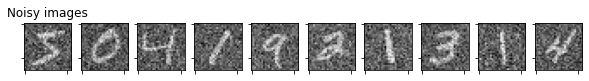

In [168]:
def corrupt(data: Tensor, sigma = 0.3) -> Tensor:
    noise = np.random.randn(*data.shape)*sigma
    return data + noise.astype(np.float32)

mnist_train_noisy = corrupt(mnist_train)
mnist_test_noisy = corrupt(mnist_test)

dtrain_ds = PairDataset(mnist_train_noisy, mnist_train)
dtest_ds = PairDataset(mnist_test_noisy, mnist_test)

plot_images(mnist_train_noisy[0:10,:,:], "Noisy images");

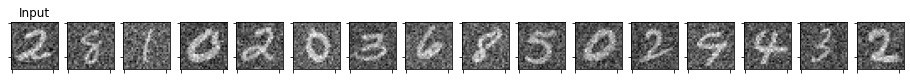

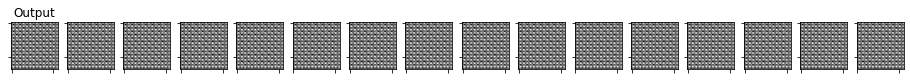

test_loss_before = 0.10077006018655316



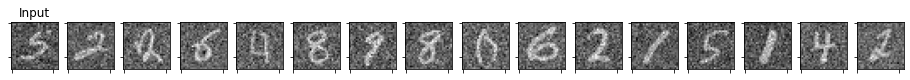

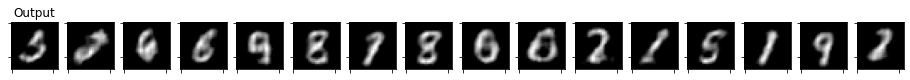

train_loss[0] = 0.03949264430010052
test_loss[0] = 0.031692085170726865



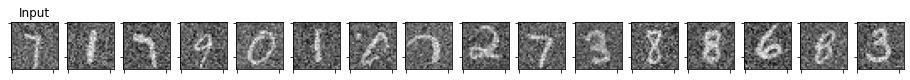

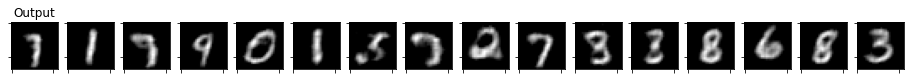

train_loss[1] = 0.031227205643680558
test_loss[1] = 0.030628316733203115



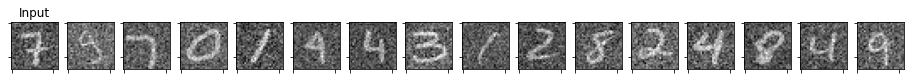

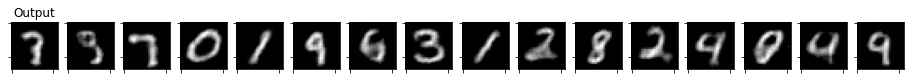

train_loss[2] = 0.030495568933183833
test_loss[2] = 0.030042142767435425



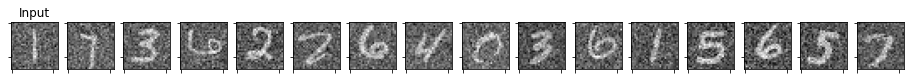

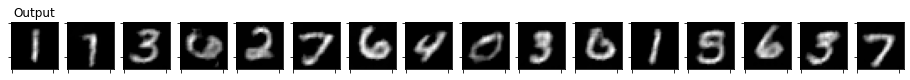

train_loss[3] = 0.030086890280024328
test_loss[3] = 0.02987360136856319



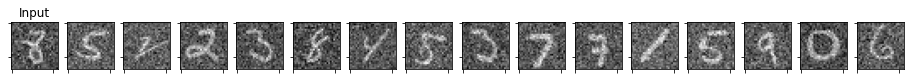

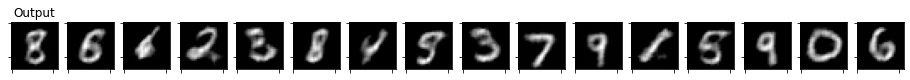

train_loss[4] = 0.029792659222952593
test_loss[4] = 0.029308881420808234



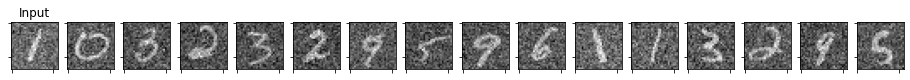

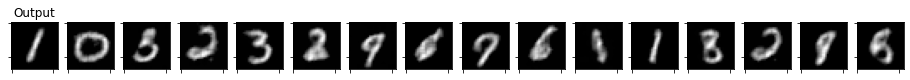

train_loss[5] = 0.029547380307304073
test_loss[5] = 0.02906184458428887



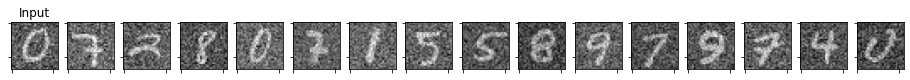

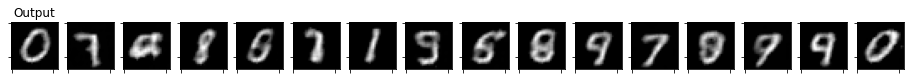

train_loss[6] = 0.029403761132503117
test_loss[6] = 0.028842021337455247



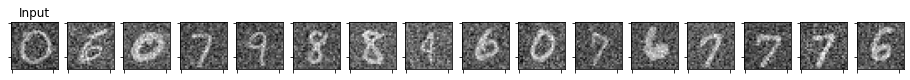

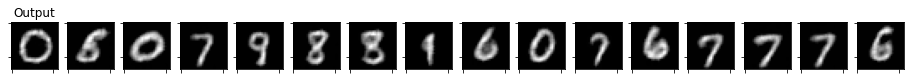

train_loss[7] = 0.0292623576833241
test_loss[7] = 0.028812787892996884



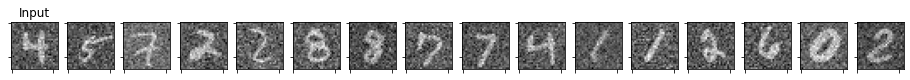

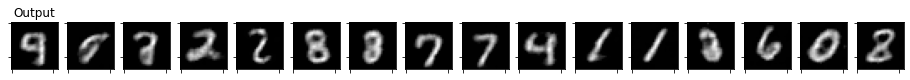

train_loss[8] = 0.02918249732657854
test_loss[8] = 0.0291131863216306



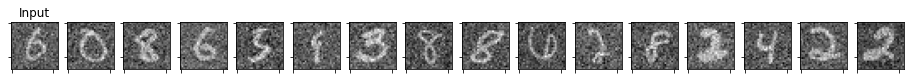

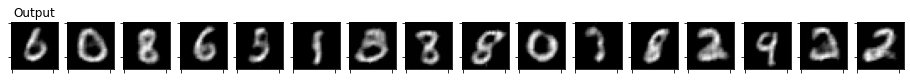

train_loss[9] = 0.029117169166440523
test_loss[9] = 0.028731049839288567



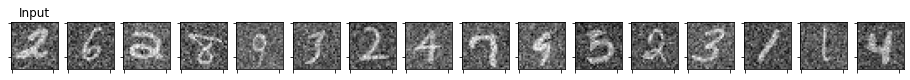

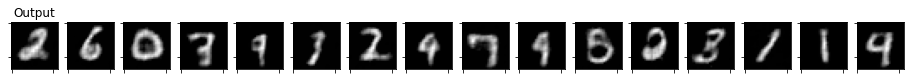

In [198]:
dae, loss_dtr, loss_dte = train(dtrain_ds, dtest_ds, Autoencoder(), MSELoss())

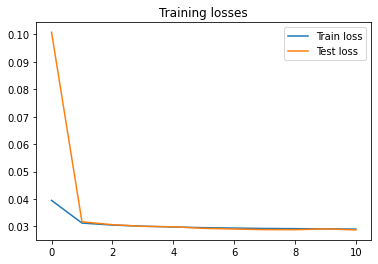

In [199]:
plot_losses(loss_dtr, loss_dte)

## Data generation

What if we wish to generate data using the decoder only?

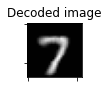

In [200]:
from torch import no_grad

# Splitting the model:
encoder = dae[0]
decoder = dae[1]

def gnerate_and_plot(encoded):
    with no_grad():
        # Decoding it:
        decoded = decoder(encoded)[:,0,:,:]

        # Is this process ok?
        plot_images(decoded, "Decoded image");
    
# Encoding and plotting one image:
encoded = encoder(mnist_test_noisy[0:1,None,:,:])
gnerate_and_plot(encoded)

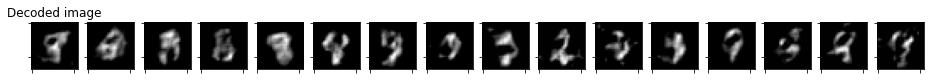

In [201]:
from torch import mean, std, tensor
from numpy.random import randn

with no_grad():
    # Estimating the normal parameters (diagonal covariance):
    encoded_test = encoder(mnist_test_noisy[0:256,None,:,:])
    enc_mean = mean(encoded_test, dim=0)[None,:,:,:]
    enc_std = std(encoded_test, dim=0)[None,:,:,:]
    
    # Generating a random encoding:
    z = randn(16,*enc_mean.shape[1:]).astype(np.float32)
    encoded = tensor(z) * enc_std + enc_mean
    
    # Decoding and plotting:
    gnerate_and_plot(encoded)

## The embedding distribution is not (granted) gaussian

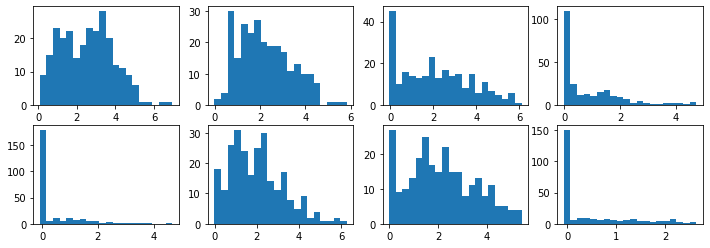

In [202]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(12,4))
for i in range(8):
    ax[i//4,i%4].hist([encoded_test[:,i,0,0]],20)
plt.show()

# Play around

- We are encoding digits in 32 numbers,  
  try encoding them in 16/64 values and check the difference.
- We are using convolutions separated in depthwise + pointwise,  
  try using less/more of them,  
  check the difference in #parameters and results.